### Environment Setup

In [ ]:
!pip install phycv opencv-python numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1

In [ ]:
!pip install av  imageio imageio-ffmpeg kornia matplotlib numpy opencv-python Pillow torch torchvision

### Preprocessing and Enhancement

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


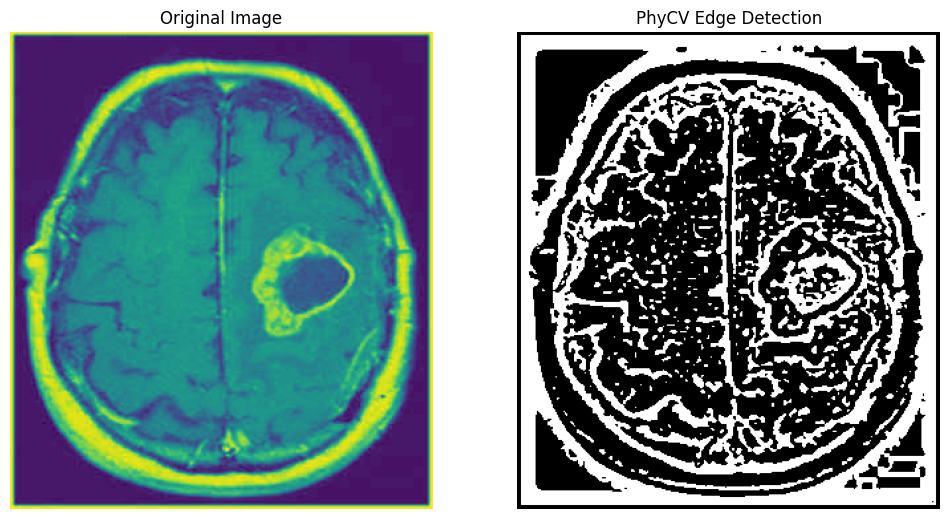

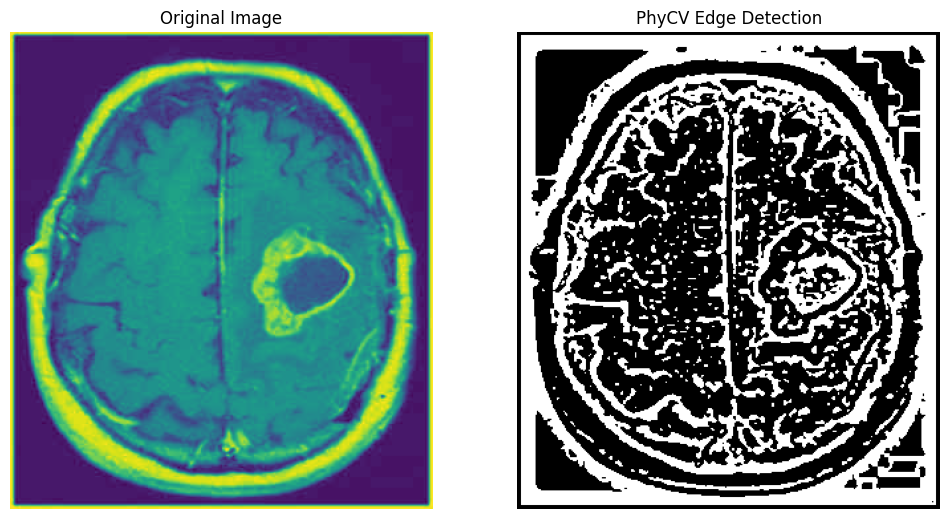

In [ ]:
"""
run PST on a single image:
All steps (load_img -> init_kernel -> apply_kernel) are performed in a single run method.

"""
import os

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image

from phycv import PST, PST_GPU


def main():
    # indicate image file, height and width of the image, and GPU device (if applicable)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    img_file = "/content/drive/Shareddrives/Test/Brain-Tumor-Detection-master/yes/Y10.jpg"
    original_image = mpimg.imread(img_file)

    output_path = "./output/"
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    # PST parameters
    S = 0.4
    W = 30
    sigma_LPF = 0.1
    thresh_min = 0.0
    thresh_max = 0.6
    morph_flag = 1

    # run PST CPU version
    pst_cpu = PST()
    pst_output_cpu = pst_cpu.run(
        img_file,
        S,
        W,
        sigma_LPF,
        thresh_min,
        thresh_max,
        morph_flag,
    )

    # run PST GPU version
    pst_gpu = PST_GPU(device=device)
    pst_output_gpu = pst_gpu.run(
        img_file,
        S,
        W,
        sigma_LPF,
        thresh_min,
        thresh_max,
        morph_flag,
    )
    pst_output_gpu = pst_output_gpu.cpu().numpy()

    # visualize the results
    f, axes = plt.subplots(1, 2, figsize=(12, 8))
    axes[0].imshow(original_image)
    axes[0].axis("off")
    axes[0].set_title("Original Image")
    axes[1].imshow(pst_output_cpu, cmap="gray")
    axes[1].axis("off")
    axes[1].set_title("PhyCV Edge Detection")
    plt.savefig(os.path.join(output_path, "PST_CPU_compare.jpg"), bbox_inches="tight")
    pst_cpu_result = Image.fromarray((pst_output_cpu * 255).astype(np.uint8))
    pst_cpu_result.save(os.path.join(output_path, "PST_CPU_output.jpg"))

    f, axes = plt.subplots(1, 2, figsize=(12, 8))
    axes[0].imshow(original_image)
    axes[0].axis("off")
    axes[0].set_title("Original Image")
    axes[1].imshow(pst_output_gpu, cmap="gray")
    axes[1].axis("off")
    axes[1].set_title("PhyCV Edge Detection")
    plt.savefig(os.path.join(output_path, "PST_GPU_compare.jpg"), bbox_inches="tight")
    pst_gpu_result = Image.fromarray((pst_output_gpu * 255).astype(np.uint8))
    pst_gpu_result.save(os.path.join(output_path, "PST_GPU_output.jpg"))
    return pst_gpu_result


pst_gpu_result = main()

###Noise Reduction


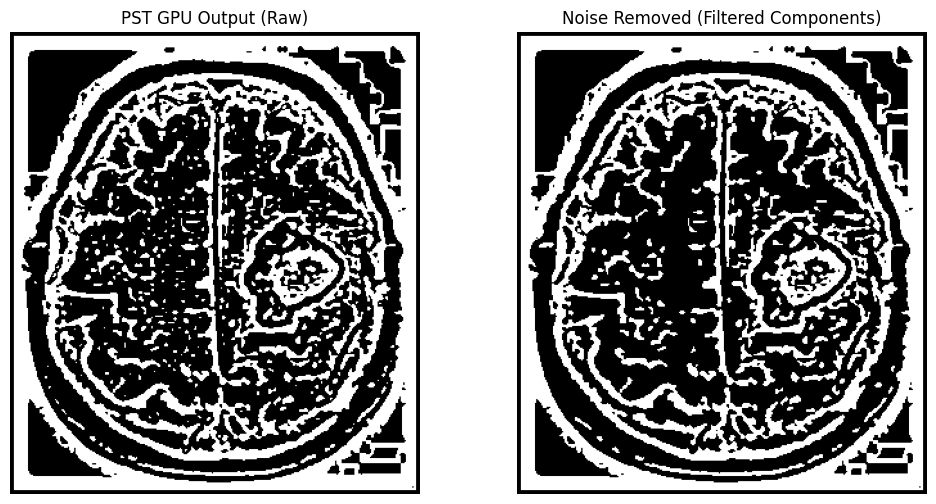

In [ ]:
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Ensure image is single-channel grayscale before converting
page_edge_gpu = np.array(pst_gpu_result.convert("L"))  # 💡 Convert to grayscale explicitly

# Convert to uint8
page_uint8 = page_edge_gpu.astype(np.uint8)

# Find connected components
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(page_uint8, connectivity=8)

# Create a mask to keep only significant components
min_size = 10
filtered_mask = np.zeros_like(page_uint8)

for i in range(1, num_labels):  # Skip background (label 0)
    area = stats[i, cv2.CC_STAT_AREA]
    if area >= min_size:
        filtered_mask[labels == i] = 255

# Display results
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(page_edge_gpu, cmap="gray")
axes[0].axis("off")
axes[0].set_title("PST GPU Output (Raw)")

axes[1].imshow(filtered_mask, cmap="gray")
axes[1].axis("off")
axes[1].set_title("Noise Removed (Filtered Components)")

plt.show()


In [ ]:
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from phycv import PST, PST_GPU

def main(img_file):  # 🔄 Accept image path as parameter
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    original_image = mpimg.imread(img_file)

    output_path = "./output/"
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    # PST parameters
    S = 0.4
    W = 30
    sigma_LPF = 0.1
    thresh_min = 0.0
    thresh_max = 0.5
    morph_flag = 1

    # Run PST GPU version
    pst_gpu = PST_GPU(device=device)
    pst_output_gpu = pst_gpu.run(
        img_file,
        S,
        W,
        sigma_LPF,
        thresh_min,
        thresh_max,
        morph_flag,
    )
    pst_output_gpu = pst_output_gpu.cpu().numpy()

    # Save the raw PST GPU output image
    base_name = os.path.basename(img_file)
    pst_gpu_result = Image.fromarray((pst_output_gpu * 255).astype(np.uint8))
    pst_gpu_result.save(os.path.join(output_path, f"PST_GPU_output_{base_name}"))

    return pst_gpu_result


In [ ]:
import glob
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Input folder and filtered output folder
no_folder = "/content/drive/Shareddrives/Test/Brain-Tumor-Detection-master/no"
filtered_output_path = "/content/drive/Shareddrives/Test/Brain-Tumor-Detection-master/no_result"
os.makedirs(filtered_output_path, exist_ok=True)

# Loop over all JPG images in 'no' folder
image_paths = glob.glob(os.path.join(no_folder, "*.jpg"))

for img_path in image_paths:
    try:
        # Step 1: Run PST and get the GPU output image
        pst_gpu_result = main(img_path)

        # Step 2: Convert result to grayscale NumPy array
        page_edge_gpu = np.array(pst_gpu_result.convert("L"))
        page_uint8 = page_edge_gpu.astype(np.uint8)

        # Step 3: Connected component filtering
        num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(page_uint8, connectivity=8)
        filtered_mask = np.zeros_like(page_uint8)
        min_size = 10

        for i in range(1, num_labels):
            area = stats[i, cv2.CC_STAT_AREA]
            if area >= min_size:
                filtered_mask[labels == i] = 255

        # Step 4: Save the filtered mask
        base_name = os.path.basename(img_path)
        save_path = os.path.join(filtered_output_path, f"filtered_{base_name}")
        Image.fromarray(filtered_mask).save(save_path)

        print(f"[✔] Saved: {save_path}")

    except Exception as e:
        print(f"[✘] Failed: {img_path} — {e}")


[✔] Saved: /content/drive/Shareddrives/Test/Brain-Tumor-Detection-master/no_result/filtered_38 no.jpg
[✔] Saved: /content/drive/Shareddrives/Test/Brain-Tumor-Detection-master/no_result/filtered_N3.jpg
[✔] Saved: /content/drive/Shareddrives/Test/Brain-Tumor-Detection-master/no_result/filtered_no 97.jpg
[✔] Saved: /content/drive/Shareddrives/Test/Brain-Tumor-Detection-master/no_result/filtered_19 no.jpg
[✔] Saved: /content/drive/Shareddrives/Test/Brain-Tumor-Detection-master/no_result/filtered_N17.jpg
[✔] Saved: /content/drive/Shareddrives/Test/Brain-Tumor-Detection-master/no_result/filtered_32 no.jpg
[✔] Saved: /content/drive/Shareddrives/Test/Brain-Tumor-Detection-master/no_result/filtered_31 no.jpg
[✔] Saved: /content/drive/Shareddrives/Test/Brain-Tumor-Detection-master/no_result/filtered_N5.jpg
[✔] Saved: /content/drive/Shareddrives/Test/Brain-Tumor-Detection-master/no_result/filtered_43 no.jpg
[✔] Saved: /content/drive/Shareddrives/Test/Brain-Tumor-Detection-master/no_result/filtere

In [ ]:
import glob
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Input folder and filtered output folder
no_folder = "/content/drive/Shareddrives/Test/Brain-Tumor-Detection-master/yes"
filtered_output_path = "/content/drive/Shareddrives/Test/Brain-Tumor-Detection-master/yes_result"
os.makedirs(filtered_output_path, exist_ok=True)

# Loop over all JPG images in 'no' folder
image_paths = glob.glob(os.path.join(no_folder, "*.jpg"))

for img_path in image_paths:
    try:
        # Step 1: Run PST and get the GPU output image
        pst_gpu_result = main(img_path)

        # Step 2: Convert result to grayscale NumPy array
        page_edge_gpu = np.array(pst_gpu_result.convert("L"))
        page_uint8 = page_edge_gpu.astype(np.uint8)

        # Step 3: Connected component filtering
        num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(page_uint8, connectivity=8)
        filtered_mask = np.zeros_like(page_uint8)
        min_size = 10

        for i in range(1, num_labels):
            area = stats[i, cv2.CC_STAT_AREA]
            if area >= min_size:
                filtered_mask[labels == i] = 255

        # Step 4: Save the filtered mask
        base_name = os.path.basename(img_path)
        save_path = os.path.join(filtered_output_path, f"filtered_{base_name}")
        Image.fromarray(filtered_mask).save(save_path)

        print(f"[✔] Saved: {save_path}")

    except Exception as e:
        print(f"[✘] Failed: {img_path} — {e}")


[✔] Saved: /content/drive/Shareddrives/Test/Brain-Tumor-Detection-master/yes_result/filtered_Y188.jpg
[✔] Saved: /content/drive/Shareddrives/Test/Brain-Tumor-Detection-master/yes_result/filtered_Y31.jpg
[✔] Saved: /content/drive/Shareddrives/Test/Brain-Tumor-Detection-master/yes_result/filtered_Y107.jpg
[✔] Saved: /content/drive/Shareddrives/Test/Brain-Tumor-Detection-master/yes_result/filtered_Y250.jpg
[✔] Saved: /content/drive/Shareddrives/Test/Brain-Tumor-Detection-master/yes_result/filtered_Y8.jpg
[✔] Saved: /content/drive/Shareddrives/Test/Brain-Tumor-Detection-master/yes_result/filtered_Y60.jpg
[✔] Saved: /content/drive/Shareddrives/Test/Brain-Tumor-Detection-master/yes_result/filtered_Y154.jpg
[✔] Saved: /content/drive/Shareddrives/Test/Brain-Tumor-Detection-master/yes_result/filtered_Y7.jpg
[✔] Saved: /content/drive/Shareddrives/Test/Brain-Tumor-Detection-master/yes_result/filtered_Y180.jpg
[✔] Saved: /content/drive/Shareddrives/Test/Brain-Tumor-Detection-master/yes_result/filt

###Disease Diagnosis

In [ ]:
import os

In [ ]:
# Define paths to tumor and non-tumor images
tumor_dir = "/content/drive/Shareddrives/Test/Brain-Tumor-Detection-master/yes_result"
no_tumor_dir = "/content/drive/Shareddrives/Test/Brain-Tumor-Detection-master/no_result"

# Count images
num_tumor = len(os.listdir(tumor_dir))
num_no_tumor = len(os.listdir(no_tumor_dir))

print(f"Number of Tumor images: {num_tumor}")
print(f"Number of No-Tumor images: {num_no_tumor}")

Number of Tumor images: 86
Number of No-Tumor images: 80


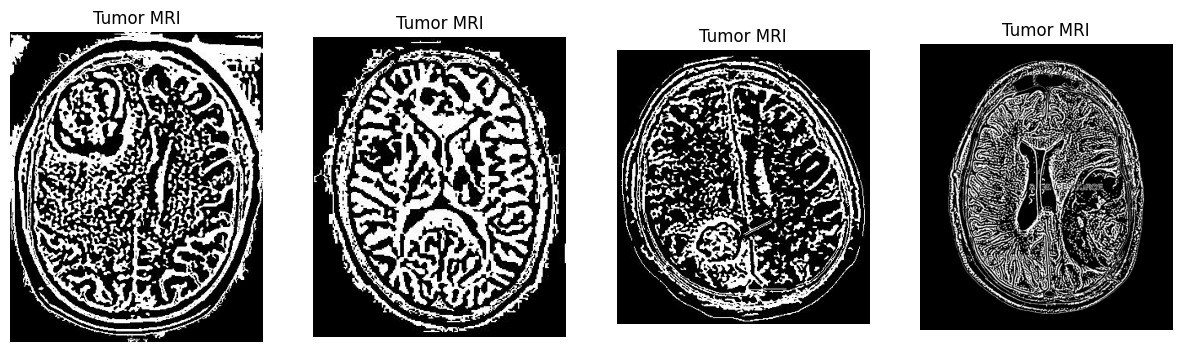

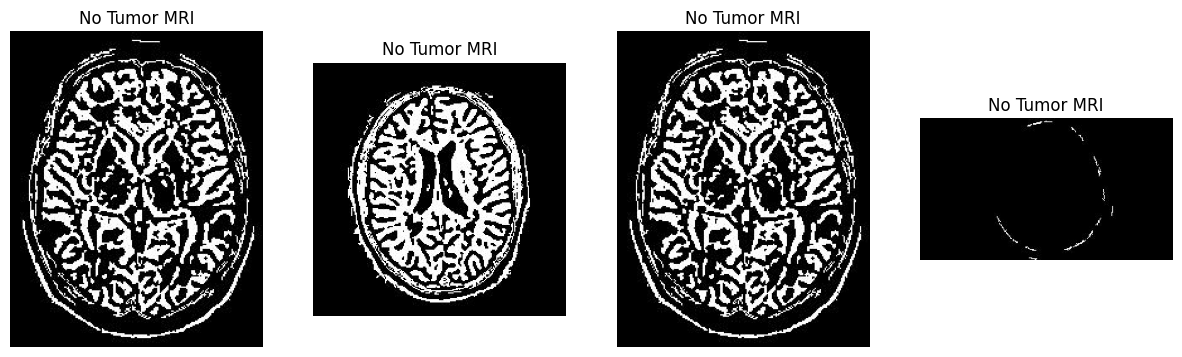

In [ ]:
import matplotlib.pyplot as plt
import cv2
import random

#display images
def show_images(folder, title, num_images=4):
    images = random.sample(os.listdir(folder), num_images)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i, img_name in enumerate(images):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(title)

    plt.show()

show_images(tumor_dir, "Tumor MRI")
show_images(no_tumor_dir, "No Tumor MRI")

In [ ]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

# Define dataset paths
tumor_dir = "/content/drive/Shareddrives/Test/Brain-Tumor-Detection-master/yes_result"
no_tumor_dir = "/content/drive/Shareddrives/Test/Brain-Tumor-Detection-master/no_result"

# Set image size
IMG_SIZE = 128  # Resize all images to 128x128 pixels

# Function to load and preprocess images
def load_and_preprocess_data(directory, label):
    images = []
    labels = []
    for file in os.listdir(directory):
        img_path = os.path.join(directory, file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize to 128x128
        img = img / 255.0  # Normalize pixel values (0-1)
        images.append(img)
        labels.append(label)  # Assign label (1 = Tumor, 0 = No Tumor)
    return images, labels

# Load tumor and non-tumor images
tumor_images, tumor_labels = load_and_preprocess_data(tumor_dir, 1)
no_tumor_images, no_tumor_labels = load_and_preprocess_data(no_tumor_dir, 0)

# Combine datasets
X = np.array(tumor_images + no_tumor_images)  # Features (images)
y = np.array(tumor_labels + no_tumor_labels)  # Labels (1 = Tumor, 0 = No Tumor)

# Reshape to match CNN input shape (add a channel dimension)
X = X.reshape(-1, IMG_SIZE, IMG_SIZE, 1)  # Shape: (num_samples, 128, 128, 1)

# Split data into Training (80%) and Validation (20%)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Print dataset shape
print(f"Training set: {X_train.shape}, Labels: {y_train.shape}")
print(f"Validation set: {X_val.shape}, Labels: {y_val.shape}")

Training set: (132, 128, 128, 1), Labels: (132,)
Validation set: (34, 128, 128, 1), Labels: (34,)


In [ ]:
def apply_clahe(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    return clahe.apply((img * 255).astype(np.uint8)) / 255.0  # Convert back to 0-1 range

# Apply CLAHE to all images
X_train = np.array([apply_clahe(img) for img in X_train])
X_val = np.array([apply_clahe(img) for img in X_val])

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the CNN model
model = Sequential([
    # First Conv layer
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    MaxPooling2D(2,2),

    # Second Conv layer
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    # Third Conv layer
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    # Flatten the features
    Flatten(),

    # Fully connected layer
    Dense(128, activation='relu'),
    Dropout(0.5),  # Prevents overfitting
    Dense(1, activation='sigmoid')  # Binary classification (Tumor or No Tumor)
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])






# Print model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_29 (Conv2D)                   │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,193 (12.60 MB)

 Trainable params: 3,304,193 (12.60 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=80)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.5957 - loss: 0.6380 - val_accuracy: 0.6176 - val_loss: 0.6468
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7030 - loss: 0.5918 - val_accuracy: 0.7647 - val_loss: 0.5804
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7155 - loss: 0.5807 - val_accuracy: 0.7647 - val_loss: 0.5513
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.6745 - loss: 0.5748 - val_accuracy: 0.7059 - val_loss: 0.5957
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.6989 - loss: 0.5274 - val_accuracy: 0.7647 - val_loss: 0.5577
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.7307 - loss: 0.5001 - val_accuracy: 0.7647 - val_loss: 0.5108
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7485 - loss: 0.5175 - val_accuracy: 0.7647 - val_loss: 0.5083
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.8053 - loss: 0.4652 - val_accuracy: 0.8235 - val_loss: 0.4864
Epoch 9/

In [ ]:
# Evaluate the model on validation data
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8603 - loss: 0.9005 
Validation Accuracy: 85.29%


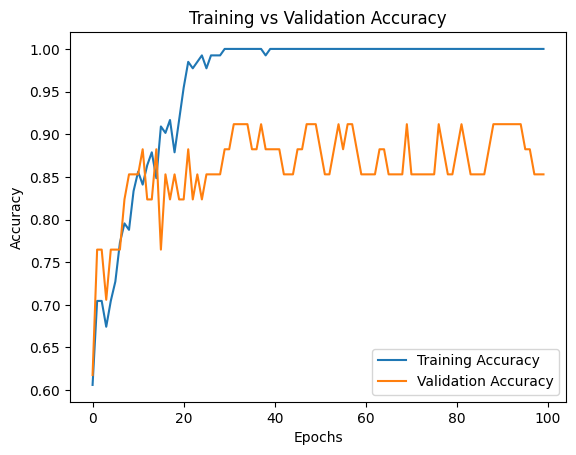

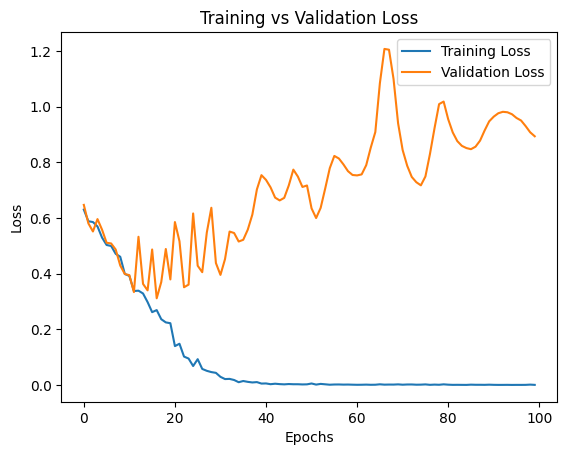

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
y_proba = model.predict(X_val)
print("ROC-AUC Score:", roc_auc_score(y_val, y_proba))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
ROC-AUC Score: 0.9523809523809523


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


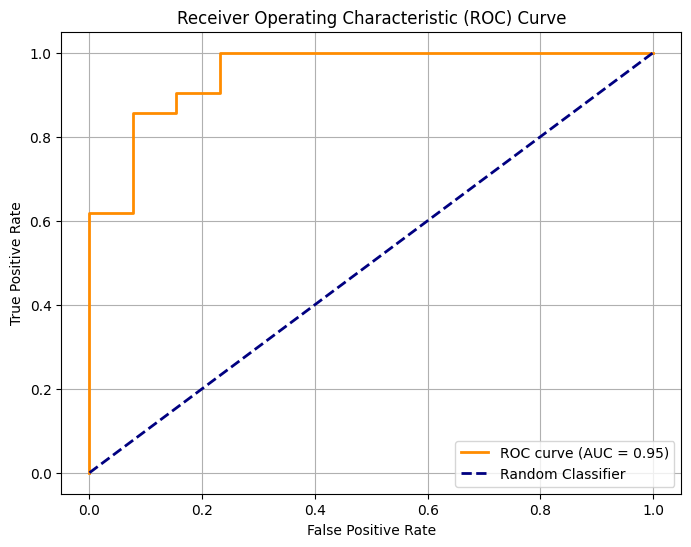

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get model predicted probabilities
y_proba = model.predict(X_val).ravel()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_val, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


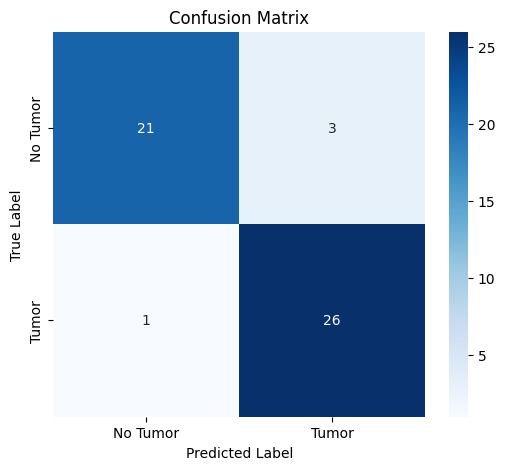


📄 Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.95      0.88      0.91        24
       Tumor       0.90      0.96      0.93        27

    accuracy                           0.92        51
   macro avg       0.93      0.92      0.92        51
weighted avg       0.92      0.92      0.92        51



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict class labels
y_pred = (model.predict(X_val) > 0.5).astype("int32")

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Tumor', 'Tumor'], yticklabels=['No Tumor', 'Tumor'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\n📄 Classification Report:")
print(classification_report(y_val, y_pred, target_names=["No Tumor", "Tumor"]))